# Cluster Membership Probability
### Using Extreme Deconvolution GMM

The data used in this file was created elsewhere.

Lindegren et al needs to be done

In [1]:
from astropy.io import fits
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import sklearn.decomposition
import seaborn as sn
import pickle
if("Cluster_analysis" in os.getcwd()):
    os.chdir("../")

from Data_handling.pca_functions import Pca_Fitting
from Data_handling.gaia_query import gaia_cone, bailer_jones_cone, concatenate_gaia_bailer
from Data_handling.vae import Encoder,Decoder, VAE , loss_function, model_train


os.chdir("Cluster_analysis")
os.getcwd()

'/Users/mattocallaghan/GES/Cluster_analysis'

In [2]:
sn.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('font', size=13)         

# Astrometric solution

So far this is a purely astrometric solution.

# 1.2 Cluster choice

Here choosing open cluster Trumpler 14


Inputting a sample of data in the open cluster region.

# 1.5 Import Data From CSV

In [3]:
os.chdir('../cluster_files')

In [4]:
gaia_eso=pd.read_csv('gaia_eso.csv')
gaia_not_eso=pd.read_csv('gaia_not_eso.csv')

In [5]:
os.chdir('../Cluster_analysis')

We create two dataframes, one with all of the GAIA ESO values and another which comes from GAIA only.

# 1.6.1 Global corections

Remove G>18
What about the parallax zero point?

https://arxiv.org/pdf/2108.02783.pdf

We use the recommendations from 294 Lindegren et al. (2018) to account for systematics found 295 within the parallax and proper-motion data. In particular, we subtract the -0.029 mas parallax zero-point 297 from all of our stars and exclude all stars fainter than 298 18th Gaia G magnitude.

In [6]:
gaia_not_eso=gaia_not_eso[gaia_not_eso['phot_g_mean_mag']<=18.0].reset_index(drop=True)
gaia_eso=gaia_eso[gaia_eso['phot_g_mean_mag']<=18.0].reset_index(drop=True)

In [67]:
gaia_not_eso

,Unnamed: 0,solution_id,DESIGNATION,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,...,RA_ICRS,DE_ICRS,rgeo,b_rgeo,B_rgeo,rpgeo,b_rpgeo,B_rpgeo,Flag,GAIA_eDR3_ID
0,0,1636042515805110273,Gaia EDR3 4252441450420820352,4252441450420820352,702956645,2016.0,282.788193,0.090897,-6.547213,0.089533,...,282.788193,-6.547213,3248.09937,2437.19043,4425.95654,2855.32617,2315.71069,3623.02954,10033,4252441450420820352
1,1,1636042515805110273,Gaia EDR3 4252441450420820480,4252441450420820480,520045408,2016.0,282.786902,0.223747,-6.548131,0.222232,...,282.786902,-6.548131,4038.64795,2439.56250,5918.26416,3988.03687,2681.29272,5453.57666,10033,4252441450420820480
2,15,1636042515805110273,Gaia EDR3 4252441454819788672,4252441454819788672,1451265992,2016.0,282.790473,0.087144,-6.547268,0.085542,...,282.790473,-6.547268,4639.32910,3500.85815,6313.65674,3612.06616,2917.94946,4607.43994,10033,4252441454819788672
3,19,1636042515805110273,Gaia EDR3 4252441454819805440,4252441454819805440,1554574821,2016.0,282.788951,0.061246,-6.543354,0.058172,...,282.788951,-6.543354,2526.39819,2165.84595,3021.51880,2598.14355,2173.01733,3145.86792,10033,4252441454819805440
4,22,1636042515805110273,Gaia EDR3 4252442137622284672,4252442137622284672,166592128,2016.0,282.744445,0.076764,-6.545756,0.083146,...,282.744445,-6.545756,7357.54004,5868.40527,9768.53320,8588.06445,6462.72070,10220.96780,10033,4252442137622284672
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24803,129557,1636042515805110273,Gaia EDR3 4254024236147403648,4254024236147403648,223319491,2016.0,282.788470,0.082114,-6.007469,0.090750,...,282.788470,-6.007469,7084.01074,4910.56494,9565.59473,6045.83057,4184.62695,8731.06445,10033,4254024236147403648
24804,129559,1636042515805110273,Gaia EDR3 4254024236147411840,4254024236147411840,104821037,2016.0,282.780248,0.057465,-6.007047,0.059235,...,282.780248,-6.007047,2100.93555,1883.03979,2459.72168,2147.17578,1872.23279,2423.75122,10033,4254024236147411840
24805,129565,1636042515805110273,Gaia EDR3 4254024304866894336,4254024304866894336,40902801,2016.0,282.775456,0.071895,-6.005157,0.070749,...,282.775456,-6.005157,7769.46533,5965.04639,11243.42680,10565.55080,5788.68164,16626.45700,10133,4254024304866894336
24806,129567,1636042515805110273,Gaia EDR3 4254024781525585920,4254024781525585920,1276606975,2016.0,282.703295,0.090482,-6.011748,0.091330,...,282.703295,-6.011748,4963.53955,3545.60669,6594.21533,3321.26025,2547.17358,4331.92773,10033,4254024781525585920


# 1.6.1  observations period and effect on solution

Lindegren et al. (2018) described that a five-parameter solu- tion is accepted only if at least six visibility periods are used (e.g. the number of groups of observations separated from other groups by a gap of at least four days, the parameter is named visibility_periods_used in the Gaia archive). The observations need to be well spread out in time to provide reliable five- parameter solutions. Here we applied a stronger filter on this parameter: visibility_periods_used>8.

In [8]:
gaia_not_eso=gaia_not_eso[gaia_not_eso['visibility_periods_used']>5].reset_index(drop=True)
gaia_eso=gaia_eso[gaia_eso['visibility_periods_used']>5].reset_index(drop=True)

# 1.6.1.1 Excess noise from clustering

Not sure what of this to include but its in the A and A document later. The error is included in my model so I mightn't include it. I might, however, include for the later learning.

We aim here to examine the fine structures in the HRD revealed by Gaia and therefore adopt a 10% relative precision criterion, which corresponds to an uncertainty on MG smaller than 0.22 mag: parallax_over_error>10.
Similarly, we apply filters on the relative flux error on the G, GBP, and GRP photometry: phot_g_mean_flux_over_error>50 (σG < 0.022 mag), phot_rp_mean_flux_over_error>20, and phot_bp_mean_flux_over_error>20 (σGXP < 0.054 mag). These criteria may remove variable stars, which are specifically studied in Gaia Collaboration (2018b).

# 1.6.2 Proper motion cuts

When making cuts we are going to assume that the GAIA ESO is a 'good' sample and use its values to define the bounds.

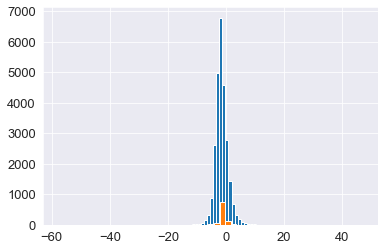

In [9]:
plt.hist(gaia_not_eso['pmra'],bins=100)
plt.hist(gaia_eso['pmra'])
plt.show()

 Make a 3 sigma clip on proper motion

In [10]:
bound=[gaia_eso['pm'].median()-3*gaia_eso['pm'].std(),gaia_eso['pm'].median()+3*gaia_eso['pm'].std()]

In [11]:
truth1=gaia_not_eso['pm']>=bound[0]

gaia_not_eso=gaia_not_eso[truth1]
truth2=gaia_not_eso['pm']<=bound[1]
gaia_not_eso=gaia_not_eso[truth2].reset_index(drop=True)
len(gaia_not_eso)

25145

In [12]:
truth1=gaia_eso['pm']>=bound[0]

gaia_eso=gaia_eso[truth1]
truth2=gaia_eso['pm']<=bound[1]
gaia_eso=gaia_eso[truth2].reset_index(drop=True)
len(gaia_eso)

984

# 1.6 Make a parallax cut 

Make a parallax cut by taking the mean and standard deviation of the parallax from the Gaia eso sample and clip by 3 sigma.

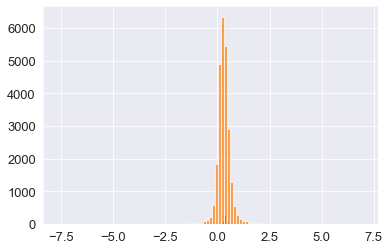

In [13]:
plt.hist(gaia_eso['parallax'],bins=100)
plt.hist(gaia_not_eso['parallax'],bins=100,alpha=0.7)
plt.show()

In [14]:
np.std(gaia_eso['parallax'])

0.36496830616464826

In [15]:
bound=[gaia_eso['parallax'].median()-3*gaia_eso['parallax'].std(),gaia_eso['parallax'].median()+3*gaia_eso['parallax'].std()]

In [16]:
truth1=gaia_not_eso['parallax']>=bound[0]
gaia_not_eso=gaia_not_eso[truth1]
truth2=gaia_not_eso['parallax']<=bound[1]
gaia_not_eso=gaia_not_eso[truth2].reset_index(drop=True)
len(gaia_not_eso)

24808

In [17]:
truth1=gaia_eso['parallax']>=bound[0]
gaia_eso=gaia_eso[truth1]
truth2=gaia_eso['parallax']<=bound[1]
gaia_eso=gaia_eso[truth2].reset_index(drop=True)
len(gaia_eso)

974

In [18]:
gaia_not_eso['parallax'].min()

-0.6881985653324588

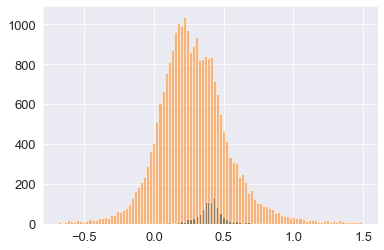

In [19]:

plt.hist(gaia_eso['parallax'],bins=90)
plt.hist(gaia_not_eso['parallax'],bins=100,alpha=0.5)
plt.show()

Even after the parallax cut of 3 sigma there are still plenty of sources.

After making a very conservative cut we are going to attempt to fit the BNN with error.

# 1.7 Making Data into Learning Format.

In [20]:
columns_parameters=['ra','dec','parallax','VRAD','pmra','pmdec']



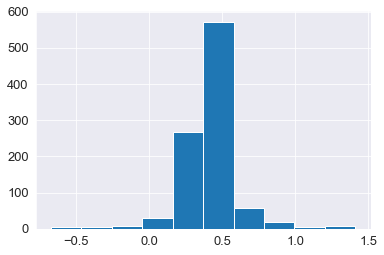

In [21]:
plt.hist((gaia_eso['parallax'].astype(float)))
plt.show()

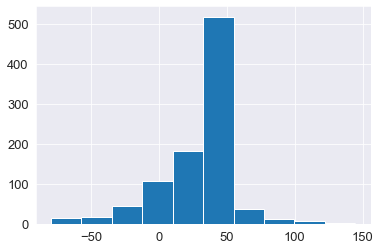

In [22]:
plt.hist((gaia_eso['VRAD'].astype(float)))
plt.show()

The radial velocity of >300 is so massively diferent so we cut it out as a huge outlier.

In [23]:
gaia_eso=gaia_eso[gaia_eso.replace('nan',0.0).fillna(0.0)['VRAD'].astype(float)<=300]



In [24]:

data=pd.concat([gaia_eso, gaia_not_eso])
input_cluster_data=data[columns_parameters]
input_cluster_data


,ra,dec,parallax,VRAD,pmra,pmdec
0,282.565031,-6.258065,0.558562,30.64,0.776237,-6.756839
1,282.583418,-6.192254,0.376980,105.47,-1.612175,-4.640347
2,282.592885,-6.329504,0.375033,39.07,-2.393408,-4.043109
3,282.596724,-6.241452,0.523459,-43.21,-3.040533,-0.931751
4,282.596739,-6.257442,0.395225,-5.76,-0.711199,-4.404408
...,...,...,...,...,...,...
24803,282.788470,-6.007469,0.030766,NaN,-2.850967,-5.665195
24804,282.780248,-6.007047,0.449862,NaN,1.577184,3.119071
24805,282.775456,-6.005157,0.002803,NaN,-1.806624,-4.939151
24806,282.703295,-6.011748,0.209325,NaN,-3.147602,-4.699169


In [25]:
columns_error=['ra_error','dec_error','parallax_error','E_VRAD','pmra_error','pmdec_error','ra_dec_corr','ra_parallax_corr','ra_pmra_corr','ra_pmdec_corr','dec_parallax_corr','dec_pmra_corr','dec_pmdec_corr','parallax_pmra_corr','parallax_pmdec_corr','pmra_pmdec_corr']
error_input=pd.concat([gaia_eso, gaia_not_eso])[columns_error]

# Covariance Error matrix

In [26]:


s = np.array([[ [ None for y in range( 6 ) ] for x in range( 6 ) ] for z in range(len(error_input))])


s[:,0,0]=error_input['ra_error'].to_numpy()**2
s[:,0,1]=np.multiply(np.multiply(error_input['ra_dec_corr'].to_numpy(),error_input['ra_error'].to_numpy()),error_input['dec_error'].to_numpy())
s[:,0,2]=np.multiply(np.multiply(error_input['ra_parallax_corr'].to_numpy(),error_input['ra_error'].to_numpy()),error_input['parallax_error'].to_numpy())
s[:,0,3]=0.0
s[:,0,4]=np.multiply(np.multiply(error_input['ra_pmra_corr'].to_numpy(),error_input['ra_error'].to_numpy()),error_input['pmra_error'].to_numpy())
s[:,0,5]=np.multiply(np.multiply(error_input['ra_pmdec_corr'].to_numpy(),error_input['ra_error'].to_numpy()),error_input['pmdec_error'].to_numpy())



s[:,1,1]=error_input['dec_error'].to_numpy()**2
s[:,1,0]=s[:,0,1]
s[:,1,2]=np.multiply(np.multiply(error_input['dec_parallax_corr'].to_numpy(),error_input['dec_error'].to_numpy()),error_input['parallax_error'].to_numpy())
s[:,1,3]=0.0
s[:,1,4]=np.multiply(np.multiply(error_input['dec_pmra_corr'].to_numpy(),error_input['dec_error'].to_numpy()),error_input['pmra_error'].to_numpy())
s[:,1,5]=np.multiply(np.multiply(error_input['dec_pmdec_corr'].to_numpy(),error_input['dec_error'].to_numpy()),error_input['pmdec_error'].to_numpy())




s[:,2,0]=s[:,0,2]
s[:,2,1]=s[:,1,2]
s[:,2,2]=error_input['parallax_error'].to_numpy()**2
s[:,2,3]=0.0
s[:,2,4]=np.multiply(np.multiply(error_input['parallax_pmra_corr'].to_numpy(),error_input['parallax_error'].to_numpy()),error_input['pmra_error'].to_numpy())
s[:,2,5]=np.multiply(np.multiply(error_input['parallax_pmdec_corr'].to_numpy(),error_input['parallax_error'].to_numpy()),error_input['pmdec_error'].to_numpy())


s[:,3,0]=0.0
s[:,3,1]=0.0
s[:,3,2]=0.0
s[:,3,3]=error_input['E_VRAD'].astype(float).to_numpy()**2 
s[:,3,4]=0.0
s[:,3,5]=0.0


s[:,4,0]=s[:,0,4]
s[:,4,1]=s[:,1,4]
s[:,4,2]=s[:,2,4]
s[:,4,3]=s[:,3,4]
s[:,4,4]=error_input['pmra_error'].to_numpy()**2
s[:,4,5]=np.multiply(np.multiply(error_input['pmra_pmdec_corr'].to_numpy(),error_input['pmra_error'].to_numpy()),error_input['pmdec_error'].to_numpy())



s[:,5,0]=s[:,0,5]
s[:,5,1]=s[:,1,5]
s[:,5,2]=s[:,2,5]
s[:,5,3]=s[:,3,5]
s[:,5,4]=s[:,4,5]
s[:,5,5]=error_input['pmdec_error'].to_numpy()**2


# Mixing Matrix R 

This follows the paper linked later. The matrix R I use is a diagonal matrix with 1 in the nth position if we have a data reading for the nth feature, and zero otherwise.

For the moment we don't need it to be very complex as we are going to only have two different cases, i.e whether or not a value has radial velocity. 

In [27]:
mixing_prep=(input_cluster_data.astype(str).to_numpy()!='nan').astype(int)


In [28]:
mixing_prep[1000]

array([1, 1, 1, 0, 1, 1])

In [29]:


R = [] #mixing matrix
for i in range(0,len(mixing_prep)):
    R.append(np.diag(mixing_prep[i]))

R=np.array(R)

# Definitions of the learning inputs

In [30]:
learning_input=input_cluster_data.replace('nan',0.0).fillna(0.0).to_numpy().astype(float)
learning_error_covariance=np.nan_to_num(s.astype(float),nan=0.0001) #this is so not to get singular matrix
learning_R=R


# 2.0 Cluster Membership Probability.

https://arxiv.org/pdf/0905.2979v2.pdf
Extreme Deconvolution GMM

In this section I'm following the above paper which adapts the GMM to noisy and missing data. I only apply this to the Gaia eso data at first, and using astrometric data.

Using Bayes Law:
$$ P(C | D)= P(D|C)P(C)\over{P(D)}$$
Let $\textbf{w}_{i}$ be the vector of observed data, and $\textbf{x}_i$ be the vector of 'true' values. Let $R$ be the matrix which projects $\textbf{x}_i$ to $\textbf{w}_i$ and let $S_i$ be a known covariance matrix, so that we assume $$\textbf{w}_i=R_i\textbf{x}_i + \text{noise}$$ where the noise is drawn from a Gaussian distribution with mean 0 and covariance $S_i$

Letting $\theta=(\alpha_j,\mu_j,V_j)$ be the parameters for a Gaussian mixture model. Following the paper above we can show that the likelihood of $\textbf{w}_i$ in terms of $\theta$ is the Gaussian mixture model: $$p(\textbf{w}_i|\theta)=\sum_j \alpha_j N(\textbf{w}_i|R_i\mu_j,T_{ij})$$
where $$T_{ij}=R_iV_jR_i^t+S_i$$

In [31]:
os.getcwd()
os.chdir('../')
from Density_estimation.xdeconv import XDGMM
os.chdir('Cluster_analysis')

We fit as per the above paper and use their E-M update algorithm. GMM returns the maximum likelihood values for the gaussian mixture parameters.

One part uses all the GES data and other uses both Gaia eso and gaia.

# Fit

In [32]:
gmm_GES=XDGMM(2).fit(learning_input[0:len(gaia_eso)],Xerr=learning_error_covariance[0:len(gaia_eso)],R=R[0:len(gaia_eso)])


gmm
endgmm


In [33]:

gmm_full=XDGMM(4).fit(learning_input,Xerr=learning_error_covariance,R=R)

gmm
endgmm


# Evaluating the Joint Probability $P(z,\textbf{w}_i)$

Let $z \in \{0,...,k\}$ be the random variable of deciding the probability of belonging to a component of the Gaussian Mixture.   
We have $$p(z,\textbf{w}_k|\theta)=p(z)p(\textbf{w}_k|z,\theta)$$
We can then find the posterior density function for $z$: $$p(z=i|\textbf{w}_k,\theta)={p(z=i|\theta)p(\textbf{w}_k|z=i,\theta)\over \sum_j p(z=j|\theta)p(\textbf{w}_k|z=j,\theta)}$$


The prior is $p(z=i|\theta)=\alpha_i$. This is the posterior probability that an observation has been generated from the $i^{th}$ component

Just Using Gaia ESO Data

In [34]:

prob_ges=gmm_GES.prob_z_given_w(learning_input[0:len(gaia_eso)],Xerr=learning_error_covariance[0:len(gaia_eso)],R=R[0:len(gaia_eso)])

Plotting

In [35]:
df=pd.DataFrame(learning_input[0:len(gaia_eso)],columns=columns_parameters)
df2=pd.DataFrame(prob_ges[:,0][0:len(gaia_eso)],columns=['prob'])
plot_df_ges=pd.concat([df,df2],axis=1)
plot_df_ges

,ra,dec,parallax,VRAD,pmra,pmdec,prob
0,282.565031,-6.258065,0.558562,30.64,0.776237,-6.756839,8.729477e-104
1,282.583418,-6.192254,0.376980,105.47,-1.612175,-4.640347,5.130710e-86
2,282.592885,-6.329504,0.375033,39.07,-2.393408,-4.043109,1.648670e-04
3,282.596724,-6.241452,0.523459,-43.21,-3.040533,-0.931751,8.311399e-263
4,282.596739,-6.257442,0.395225,-5.76,-0.711199,-4.404408,8.753890e-43
...,...,...,...,...,...,...,...
969,282.925362,-6.313343,0.681330,32.77,-1.763939,-4.189295,9.886331e-01
970,282.933178,-6.248270,0.518017,18.74,1.297329,2.485403,0.000000e+00
971,282.937478,-6.275078,0.424426,35.36,-1.555129,-4.222299,9.998220e-01
972,282.944467,-6.279355,0.291889,1.69,-1.445338,-2.678426,1.742775e-41


In [36]:
sum(plot_df_ges[0:len(gaia_eso)]['prob']>=0.99)

468

Just training and evaluating on the original sample gives 400 members with probability >=0.99

We not plot these values vs their membership.

# GAIA ESO Train and evaluate.

<AxesSubplot:xlabel='pmdec', ylabel='VRAD'>

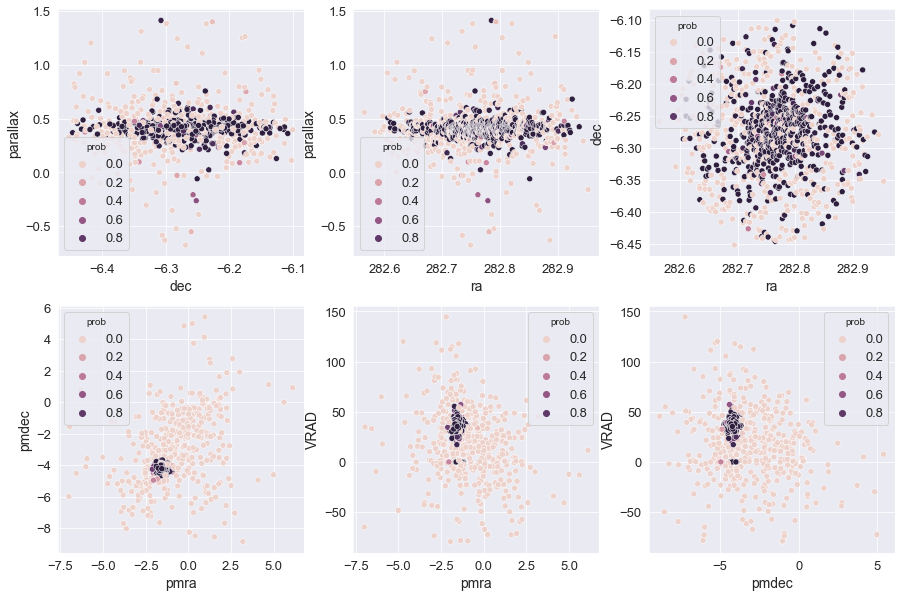

In [37]:
fig, axs = plt.subplots(2, 3)
fig.set_figwidth(15)
fig.set_figheight(10)
sn.scatterplot(data=plot_df_ges,x='dec',y='parallax',hue='prob',ax=axs[0,0])
sn.scatterplot(data=plot_df_ges,x='ra',y='parallax',hue='prob',ax=axs[0,1])
sn.scatterplot(data=plot_df_ges,x='ra',y='dec',hue='prob',ax=axs[0,2])

sn.scatterplot(data=plot_df_ges,x='pmra',y='pmdec',hue='prob',ax=axs[1,0])
sn.scatterplot(data=plot_df_ges,x='pmra',y='VRAD',hue='prob',ax=axs[1,1])
sn.scatterplot(data=plot_df_ges,x='pmdec',y='VRAD',hue='prob',ax=axs[1,2])

# GAIA ESO and GAIA Train and evaluate.

This is a 3 compoennt GMM

In [39]:

prob_full=gmm_full.prob_z_given_w(learning_input,Xerr=learning_error_covariance,R=R)
df=pd.DataFrame(learning_input,columns=columns_parameters)



In [46]:
df2=pd.DataFrame(prob_full[:,1],columns=['prob'])
plot_df_full=pd.concat([df,df2],axis=1)
plot_df_full

,ra,dec,parallax,VRAD,pmra,pmdec,prob
0,282.565031,-6.258065,0.558562,30.64,0.776237,-6.756839,4.234866e-102
1,282.583418,-6.192254,0.376980,105.47,-1.612175,-4.640347,4.212212e-107
2,282.592885,-6.329504,0.375033,39.07,-2.393408,-4.043109,5.072590e-05
3,282.596724,-6.241452,0.523459,-43.21,-3.040533,-0.931751,1.245549e-304
4,282.596739,-6.257442,0.395225,-5.76,-0.711199,-4.404408,1.793793e-53
...,...,...,...,...,...,...,...
25777,282.788470,-6.007469,0.030766,0.00,-2.850967,-5.665195,5.522815e-29
25778,282.780248,-6.007047,0.449862,0.00,1.577184,3.119071,0.000000e+00
25779,282.775456,-6.005157,0.002803,0.00,-1.806624,-4.939151,3.822749e-07
25780,282.703295,-6.011748,0.209325,0.00,-3.147602,-4.699169,4.593510e-18


In [47]:
sum(plot_df_full[0:len(gaia_eso)]['prob']>=0.99)

428

Now there are only 300 objects in the original GES sample which are identified as being part of the cluster, this is verified by the following plots.

GAIA ESO AND GAIA

<AxesSubplot:title={'center':'hello'}, xlabel='pmdec', ylabel='VRAD'>

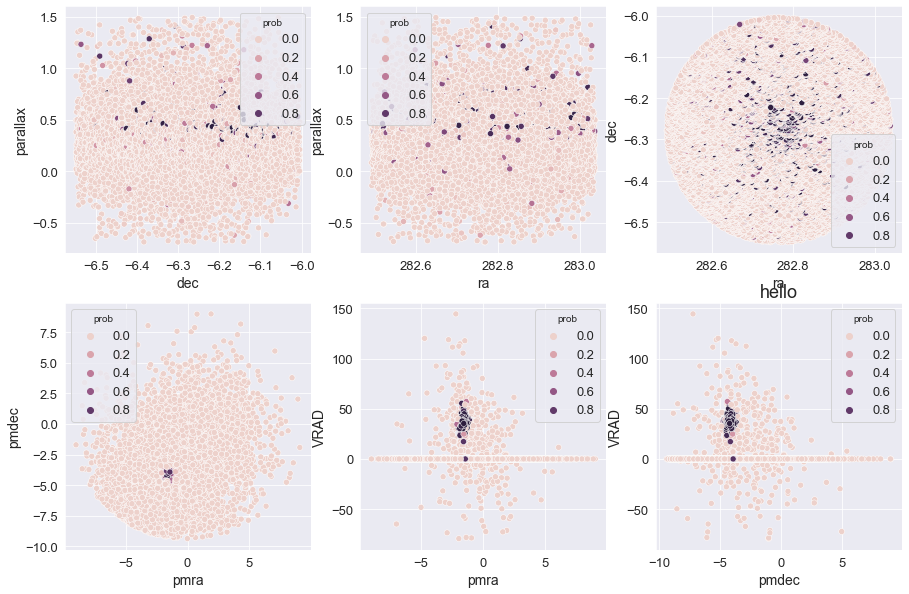

In [48]:
fig, axs = plt.subplots(2, 3)
fig.set_figwidth(15)
fig.set_figheight(10)
plt.title('hello')
sn.scatterplot(data=plot_df_full,x='dec',y='parallax',hue='prob',ax=axs[0,0])
sn.scatterplot(data=plot_df_full,x='ra',y='parallax',hue='prob',ax=axs[0,1])
sn.scatterplot(data=plot_df_full,x='ra',y='dec',hue='prob',ax=axs[0,2])

sn.scatterplot(data=plot_df_full,x='pmra',y='pmdec',hue='prob',ax=axs[1,0])
sn.scatterplot(data=plot_df_full,x='pmra',y='VRAD',hue='prob',ax=axs[1,1])
sn.scatterplot(data=plot_df_full,x='pmdec',y='VRAD',hue='prob',ax=axs[1,2])


# 2.2 Train on Gaia ESO and evaluate on GAIA plus GAIA ESO

We now see what happens if we train on a 'good' sample, that being the GAIA ESO and then apply to a much larger data set, with also less information attached to it.

In [49]:

comp=gmm_GES.prob_z_given_w(learning_input,Xerr=learning_error_covariance,R=R)
df=pd.DataFrame(learning_input,columns=columns_parameters)
df2=pd.DataFrame(comp[:,0],columns=['prob'])
plot_df=pd.concat([df,df2],axis=1)
plot_df

,ra,dec,parallax,VRAD,pmra,pmdec,prob
0,282.565031,-6.258065,0.558562,30.64,0.776237,-6.756839,8.729477e-104
1,282.583418,-6.192254,0.376980,105.47,-1.612175,-4.640347,5.130710e-86
2,282.592885,-6.329504,0.375033,39.07,-2.393408,-4.043109,1.648670e-04
3,282.596724,-6.241452,0.523459,-43.21,-3.040533,-0.931751,8.311399e-263
4,282.596739,-6.257442,0.395225,-5.76,-0.711199,-4.404408,8.753890e-43
...,...,...,...,...,...,...,...
25777,282.788470,-6.007469,0.030766,0.00,-2.850967,-5.665195,7.818712e-26
25778,282.780248,-6.007047,0.449862,0.00,1.577184,3.119071,0.000000e+00
25779,282.775456,-6.005157,0.002803,0.00,-1.806624,-4.939151,1.708513e-04
25780,282.703295,-6.011748,0.209325,0.00,-3.147602,-4.699169,6.489995e-16


In [50]:
sum(plot_df[0:len(gaia_eso)]['prob']>=0.99)

468

As we expect this gives us the same number of members >=0.99 probability from the Gaia_eso sample

Now we see this evaluated on our full dataset.

<AxesSubplot:xlabel='pmdec', ylabel='VRAD'>

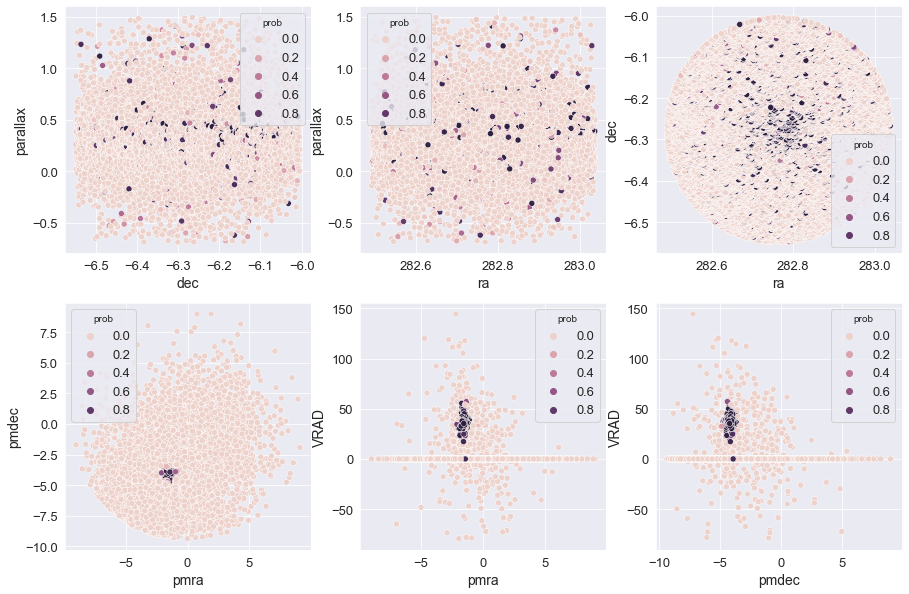

In [51]:
fig, axs = plt.subplots(2, 3)
fig.set_figwidth(15)
fig.set_figheight(10)
sn.scatterplot(data=plot_df,x='dec',y='parallax',hue='prob',ax=axs[0,0])
sn.scatterplot(data=plot_df,x='ra',y='parallax',hue='prob',ax=axs[0,1])
sn.scatterplot(data=plot_df,x='ra',y='dec',hue='prob',ax=axs[0,2])

sn.scatterplot(data=plot_df,x='pmra',y='pmdec',hue='prob',ax=axs[1,0])
sn.scatterplot(data=plot_df,x='pmra',y='VRAD',hue='prob',ax=axs[1,1])
sn.scatterplot(data=plot_df,x='pmdec',y='VRAD',hue='prob',ax=axs[1,2])

Now we evaluate it only on the GAIA data

<AxesSubplot:xlabel='pmdec', ylabel='VRAD'>

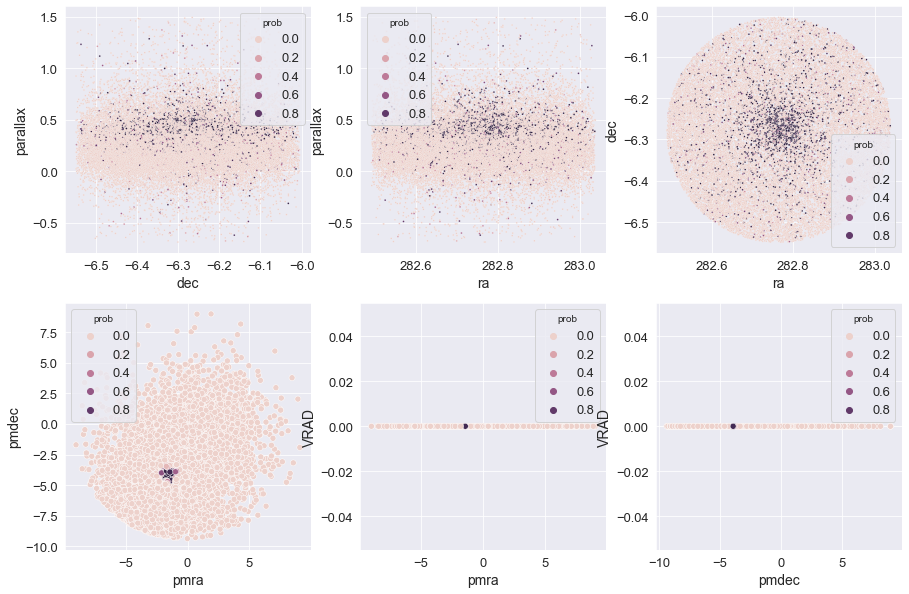

In [52]:
fig, axs = plt.subplots(2, 3)
fig.set_figwidth(15)
fig.set_figheight(10)
sn.scatterplot(data=plot_df[len(gaia_eso):],x='dec',y='parallax',hue='prob',ax=axs[0,0],s=3)
sn.scatterplot(data=plot_df[len(gaia_eso):],x='ra',y='parallax',hue='prob',ax=axs[0,1],s=3)
sn.scatterplot(data=plot_df[len(gaia_eso):],x='ra',y='dec',hue='prob',ax=axs[0,2],s=3)

sn.scatterplot(data=plot_df[len(gaia_eso):],x='pmra',y='pmdec',hue='prob',ax=axs[1,0])
sn.scatterplot(data=plot_df[len(gaia_eso):],x='pmra',y='VRAD',hue='prob',ax=axs[1,1])
sn.scatterplot(data=plot_df[len(gaia_eso):],x='pmdec',y='VRAD',hue='prob',ax=axs[1,2])

# Colour Magnitude Diagrams

## Here we are going to analyse the HR diagrams

As per recommended: We also exclude all stars with $gaiadr2.phot bp rp excess factor  >1.5+0.03·(GBP - GRP )^2$ , as it is a sign of serious colour systematic errors.

https://www.aanda.org/articles/aa/pdf/2018/08/aa32843-18.pdf

# Mean absolute magnitude used using the Posterior estimate for distance from parallax from Bailer Jones.
They compare very well.

In [53]:
def mean_basolute_mag_g_band(selection_gaia):

    selection_gaia['mean_absolute_mag_g_band']=selection_gaia['phot_g_mean_mag']-5*np.log10(selection_gaia['rgeo'])+5
    return selection_gaia

def mean_basolute_mag_g_band_parallax(selection_gaia):

    selection_gaia['mean_absolute_mag_g_band_p']=selection_gaia['phot_g_mean_mag']+5*np.log10(selection_gaia['parallax']*0.001)+5
    return selection_gaia

In [54]:
df_diagram=pd.concat([plot_df.reset_index(),data.reset_index()],axis=1)
df_diagram_full=pd.concat([plot_df_full.reset_index(),data.reset_index()],axis=1)

In [55]:
mean_basolute_mag_g_band(df_diagram)
mean_basolute_mag_g_band(df_diagram_full)

,index,ra,dec,parallax,VRAD,pmra,pmdec,prob,level_0,Unnamed: 0,...,RA_ICRS,DE_ICRS,rgeo,b_rgeo,B_rgeo,rpgeo,b_rpgeo,B_rpgeo,Flag,mean_absolute_mag_g_band
0,0,282.565031,-6.258065,0.558562,30.64,0.776237,-6.756839,4.234866e-102,0,0,...,282.565031,-6.258065,1942.98157,1618.71545,2489.67163,1923.29565,1666.32056,2345.46167,10033,5.377983
1,1,282.583418,-6.192254,0.376980,105.47,-1.612175,-4.640347,4.212212e-107,1,1,...,282.583418,-6.192254,6141.48389,3163.27856,10115.85840,3446.87402,2693.09326,5311.75977,10033,3.869186
2,2,282.592885,-6.329504,0.375033,39.07,-2.393408,-4.043109,5.072590e-05,2,3,...,282.592885,-6.329504,2671.46338,2193.52368,3324.61035,2677.84912,2291.58057,3349.83423,10033,4.753740
3,3,282.596724,-6.241452,0.523459,-43.21,-3.040533,-0.931751,1.245549e-304,3,4,...,282.596724,-6.241452,1887.64343,1726.50842,2108.31055,1788.85913,1661.42944,1947.09448,10033,4.844798
4,4,282.596739,-6.257442,0.395225,-5.76,-0.711199,-4.404408,1.793793e-53,4,5,...,282.596739,-6.257442,2360.14062,2176.29297,2672.13403,2255.69653,2041.00903,2474.74609,10033,4.017714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25777,25777,282.788470,-6.007469,0.030766,0.00,-2.850967,-5.665195,5.522815e-29,24803,129557,...,282.788470,-6.007469,7084.01074,4910.56494,9565.59473,6045.83057,4184.62695,8731.06445,10033,3.015978
25778,25778,282.780248,-6.007047,0.449862,0.00,1.577184,3.119071,0.000000e+00,24804,129559,...,282.780248,-6.007047,2100.93555,1883.03979,2459.72168,2147.17578,1872.23279,2423.75122,10033,4.919543
25779,25779,282.775456,-6.005157,0.002803,0.00,-1.806624,-4.939151,3.822749e-07,24805,129565,...,282.775456,-6.005157,7769.46533,5965.04639,11243.42680,10565.55080,5788.68164,16626.45700,10133,2.587664
25780,25780,282.703295,-6.011748,0.209325,0.00,-3.147602,-4.699169,4.593510e-18,24806,129567,...,282.703295,-6.011748,4963.53955,3545.60669,6594.21533,3321.26025,2547.17358,4331.92773,10033,3.746492


In [56]:
len(df_diagram[df_diagram['prob']>=0.9])
len(df_diagram_full[df_diagram_full['prob']>=0.9])

1718

In [57]:
data_for_hr1=df_diagram[df_diagram['prob']>=0.9]
data_for_hr2=df_diagram[df_diagram['prob']<0.9]

## This is what was trained on GAIA ESO and evaluated everywhere.

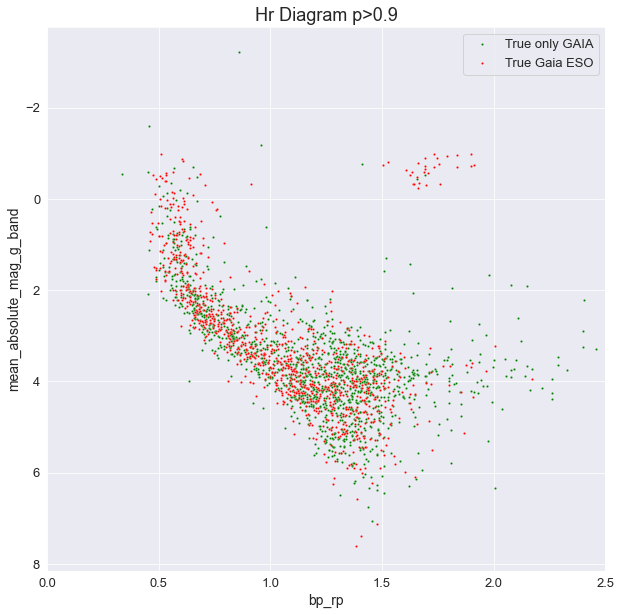

In [58]:

f, axes = plt.subplots(1, 1)
f.set_figheight(10)
f.set_figwidth(10)
scatter=data_for_hr1[len(gaia_eso):]
sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],ax=axes,label='True only GAIA',s=5,color='g')

scatter=data_for_hr1[:len(gaia_eso)]
sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],ax=axes,label='True Gaia ESO',s=5,color='r')

scatter=data_for_hr2
#sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],ax=axes,label='False',s=15,alpha=0.7)

axes.set_xlim(0,2.5)
axes.invert_yaxis()
plt.legend()
axes.set_title("Hr Diagram p>0.9")
plt.show()

# What was trained and evaluated on the whole of the data.

In [284]:
p=0.999
data_for_hr1_full=df_diagram_full[df_diagram_full['prob']>=p]
data_for_hr2_full=df_diagram_full[df_diagram_full['prob']<p]

In [285]:
hrr=df_diagram_full[df_diagram_full['rgeo']<2500]
hrr=hrr[hrr['rgeo']>2000]

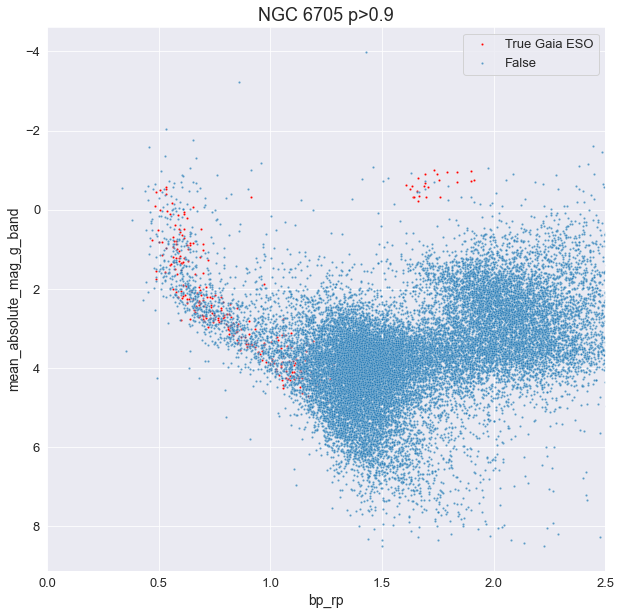

In [286]:
f, axes = plt.subplots(1, 1)
f.set_figheight(10)
f.set_figwidth(10)
scatter=data_for_hr1_full[len(gaia_eso):]
sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],ax=axes,s=5,label='True only GAIA',color='g')

scatter=data_for_hr1_full[:len(gaia_eso)]
sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],ax=axes,s=5,label='True Gaia ESO',color='r')

scatter=data_for_hr2_full
sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],ax=axes,label='False',s=5,alpha=0.7)

axes.set_xlim(0,2.5)
axes.invert_yaxis()
plt.legend()
axes.set_title("NGC 6705 p>0.9")
plt.show()

See jackson paper for comparison. Using the three component one with all of the data is good.

# Classified by both:

In [287]:
df_diagram_full['prob_other']=df_diagram['prob']

In [288]:
data_for_hr1=df_diagram_full[df_diagram_full['prob']>=0.9]
data_for_hr1both=data_for_hr1[data_for_hr1['prob_other']>=0.9]
data_for_hr2=df_diagram_full[df_diagram_full['prob_other']>=0.9]
data_for_hr2=data_for_hr2[data_for_hr2['prob']<0.9]

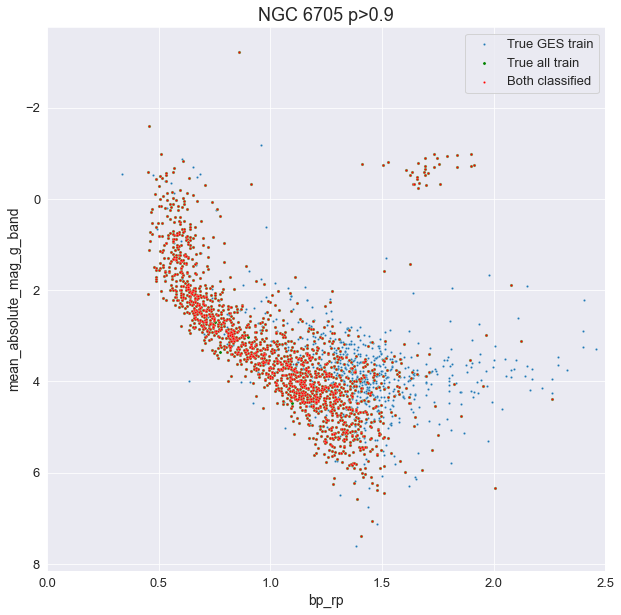

In [289]:
f, axes = plt.subplots(1, 1)
f.set_figheight(10)
f.set_figwidth(10)




scatter=data_for_hr2
sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],ax=axes,label='True GES train',s=5)

scatter=data_for_hr1
sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],ax=axes,s=10,label='True all train',color='green')



scatter=data_for_hr1both
sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],ax=axes,s=5,label='Both classified',color='r')


axes.set_xlim(0,2.5)
axes.invert_yaxis()
plt.legend()
axes.set_title("NGC 6705 p>0.9")
plt.show()

# Posterior.
https://arxiv.org/pdf/1405.4895.pdf

Plotting the parameters vs the expected values.

Saving files



In [290]:
data_for_colour=df_diagram_full#[['bp_rp','mean_absolute_mag_g_band','prob','ra','dec','parallax','VRAD','pmra','pmdec','phot_g_mean_mag','bp_g','g_rp','rgeo']]

In [291]:
os.chdir('../cluster_files')
data_for_colour.to_csv('vae_data.csv')
